# PROJECT: CUSTOMER SEGMENTATION & PREDICTION

Customer segmentation is the process of dividing potential customers in a given market into discrete groups based on common charactersticstics. Customer Segmentation can help companies to better tailor their marketing efforts to each customer category effectively and efficiently, getting higher quality revenues.

In [608]:
# dispaly customer segmentation
from IPython.display import Image
Image(url= "https://blog.intercomassets.com/blog/wp-content/uploads/2020/10/Custome.r-segmentation-performance-matrix.png", width=800, unconfined=True)



In this project, I first divide products into 7 groups by using NLP and KMeans, and then use characteristics including preferred product categories, purchase frequencies, purchased value, etc. to devide customers into 11 groups. At last, I found the optimal model for customer category prediction for the company.

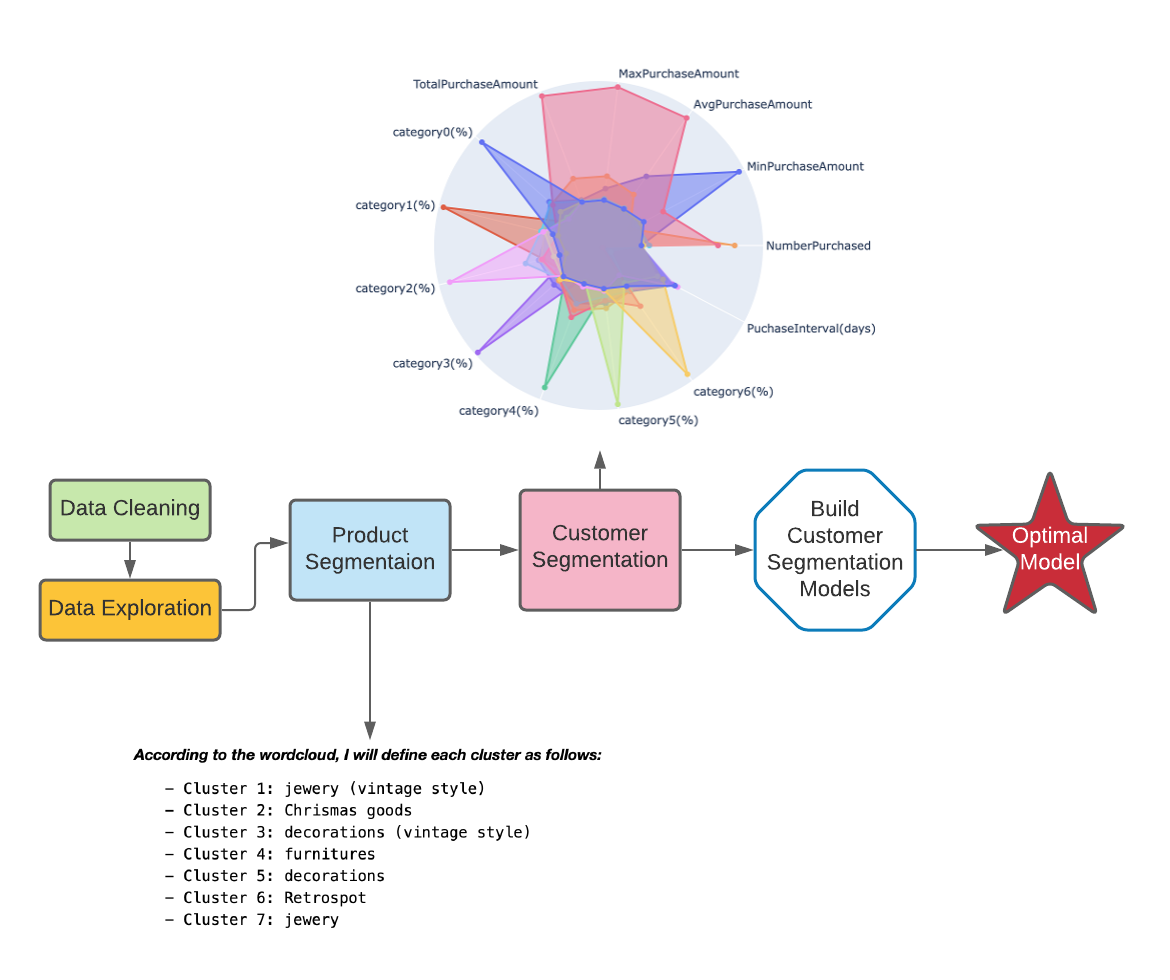

In [611]:
# project process & result
Image(filename='process.png') 

Data Source: https://www.kaggle.com/carrie1/ecommerce-data

# 1 Data Preparation

## 1.1 Import Data 

In [128]:
import os
import pandas as pd

wd = os.getcwd()
path = os.path.join(wd, "data.csv")
with open(path) as f:
    data = pd.read_csv(path, encoding = "ISO-8859-1", dtype={"CustomerID": str, "InvoiceID": str})
    
# convert date column to datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
display(data.head())

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

The meaning of each column is described below:
-	InvoiceNo: Invoice number, represents each unique transaction. 
-	StockCode: Product code, represents each unique product. 
-	Description: Product name. 
-	Quantity: The quantities of each product per transaction. 
-	InvoiceDate: Invoice Date and time, represents the day and time when each transaction was generated. 
-	UnitPrice: Unit price. 
-	CustomerID: Customer number, represents each unique customer.
-	Country: Country name, represents the name of the country where each customer resides.

In [129]:
print("There are %d columns and %d rows in the dataset."%(data.shape[1], data.shape[0]))

There are 8 columns and 541909 rows in the dataset.


## 1.2 Clean Data

### 1.2.1 Dealing with Nulls

In [130]:
# check column types and number of null values
column_types = pd.DataFrame(data.dtypes).T.rename(index = {0:"column type"})
num_nulls = pd.DataFrame(data.isnull().sum()).T.rename(index = {0:"number of nulls"})
percentage_nulls = pd.DataFrame(data.isnull().sum() / data.shape[0]*100).T.rename(index = {0:"percentage of nulls"})
frames = [column_types, num_nulls, percentage_nulls]

result = pd.concat(frames)
display(result)

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type            object    object      object    int64  datetime64[ns]   
number of nulls             0         0        1454        0               0   
percentage of nulls         0         0    0.268311        0               0   

                    UnitPrice CustomerID Country  
column type           float64     object  object  
number of nulls             0     135080       0  
percentage of nulls         0    24.9267       0

Since the percentage of rows that contains nulls is less than 30%, and thus I decide to delete all the rows containing nulls.

In [131]:
# drop NAs
data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)
print("After dropping NAs, number of records: ", data.shape[0])
# drop duplicates
data.drop_duplicates(inplace = True)
print("After dropping duplicates, number of records: ", data.shape[0])

After dropping NAs, number of records:  406829
After dropping duplicates, number of records:  401604


### 1.2.2 Dealing with Canceled Orders

In [122]:
num_products_by_transaction = data.groupby(["InvoiceNo", "CustomerID"])["Quantity"].sum().to_frame(name = 'Quantity').reset_index()
display(num_products_by_transaction.sort_values("InvoiceNo", ascending = False).head(10))
display(num_products_by_transaction.sort_values("Quantity", ascending = False).head(10))

InvoiceNo CustomerID  Quantity
22189   C581569      17315        -6
22188   C581568      15311        -5
22187   C581499      15498        -1
22186   C581490      14397       -23
22185   C581484      16446    -80995
22184   C581470      17924        -4
22183   C581468      13599       -22
22182   C581466      13883        -7
22181   C581465      15755       -10
22180   C581464      15951        -7

InvoiceNo CustomerID  Quantity
18503    581483      16446     80995
1909     541431      12346     74215
8112     556917      12415     15049
10612    563076      14646     14730
14371    572035      14646     13392
12419    567423      17450     12572
17360    578841      13256     12540
6437     552883      14646     12266
10843    563614      12415     12196
10344    562439      12931     11848

In [614]:
num_products_by_transaction[num_products_by_transaction["CustomerID"] == "13883"]

InvoiceNo CustomerID  Quantity  whether_canceled
4696     548533      13883       457                 0
6030     551958      13883       200                 0
6031     551959      13883        55                 0
6033     551961      13883       192                 0
17556    579283      13883       532                 0
18957   C541418      13883       -12                 1
19947   C553033      13883       -48                 1
20032   C554273      13883        -1                 1
22182   C581466      13883        -7                 1

As we can see, there exist negative value of quantities, which may because of customer cancaling orders. So how many orders has been canceled?

In [123]:
import numpy as np
# canceled orders
num_products_by_transaction["whether_canceled"] = np.where(num_products_by_transaction["Quantity"] < 0, 1, 0)
# number of canceled orders
num_canceled = np.sum(num_products_by_transaction["whether_canceled"])
# percentage of canceled orders
percentage_canceled_orders =  num_canceled/ len(num_products_by_transaction) * 100
print("Numebr of canceled orders: {}".format(num_canceled))
print("Number of canceled orderes: {:.2f}%".format(percentage_canceled_orders))

Numebr of canceled orders: 3654
Number of canceled orderes: 16.47%


There are 3654 orders are cancled, which is 16.47% of the total number of orders.

In order to improve the accuracy, we need to remove the canceled orders. Each canceled order contains two transactions, one is the ordering transaction, another is the canceling transaction. Therefore, I will 
- First delete the rows contains negative order quantity values. 
- Then reduce the order quantity for the corresponding customer.

In [132]:
indexes_to_be_delete = []

for index, series in data.iterrows():
    if series["Quantity"] > 0:
        continue
    
    df_temp = data[(data["CustomerID"] == series["CustomerID"]) & \
                   (data["InvoiceDate"] < series["InvoiceDate"]) & \
                   (data["StockCode"] == series["StockCode"]) & \
                   (data["Quantity"] > 0)].copy()
    
    if df_temp.shape == 0:
        continue
    
    #### First delete the rows contains negative order quantity values. ####
    
    indexes_to_be_delete.append(index)
    
    #### Then reduce the order quantity for the corresponding customer. ####
    
    # if before the cusotmer cancel the order, there is only one transaction, then delete row of that transaction
    if df_temp.shape[0] == 1:
        indexes_to_be_delete.append(df_temp.index[0])
        
    # if before the customer cancel the order, there is more than one transactions, then delete the last transaction
    if df_temp.shape[0] > 1:
        df_temp.sort_index(axis=0 ,ascending=False, inplace = True)
        
        for index_temp, series_temp in df_temp.iterrows():
            # if the order quantity in last transaction is less than the canceled quantity, then goes to the next last transaction 
            if -series["Quantity"] > series_temp["Quantity"]:
                continue
            else:
                indexes_to_be_delete.append(index_temp)
                

In [150]:
clean_data = data.drop(indexes_to_be_delete)
print("After finish dealing with canceled orders in the datase, the number of rows reduced to %d"%(clean_data.shape[0]))

After finish dealing with canceled orders in the datase, the number of rows reduced to 380630


# 2 Data Exploration

In [153]:
num_products = data.StockCode.nunique()
num_customers = data.CustomerID.nunique()
num_transactions = data.InvoiceNo.nunique()
print("Number of total unique products: %d\nNumber of total unique customers: %d\nNumber of total unique transactions: %d"%\
     (num_products, num_customers, num_transactions))

Number of total unique products: 3684
Number of total unique customers: 4372
Number of total unique transactions: 22190


## 2.1 Orders

###  2.1.1 #Orders by Country

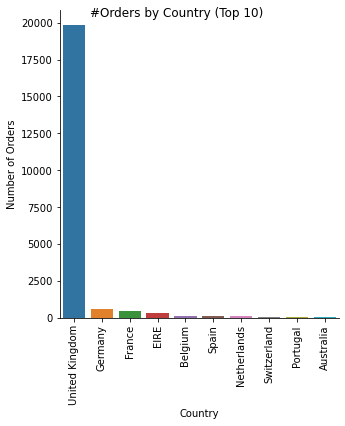

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

temp = data[["CustomerID", "InvoiceNo", "Country"]].groupby(["CustomerID", "InvoiceNo", "Country"]).count().reset_index(drop = False)
order_by_country = temp["Country"].value_counts()
temp = order_by_country.head(10).reset_index(drop = False)

# visulize the number of orders of 5 countries with the highest number of orders
g = sns.catplot(x = "index", y = "Country", data = temp, kind = "bar")
g.set(xlabel = "Country", ylabel = "Number of Orders")
g.fig.suptitle("#Orders by Country (Top 10)")
plt.xticks(rotation = 90)
g.savefig("orderbycountry.png", dmi = 300, bbox_inches='tight')
plt.show()

From the the bar plot, orders are mainly dominated by United Kingdom.

### 2.1.2 Basket Price

#### 2.1.2.1 Create Basket Price DataFrame Group by InvoiceNo and CustomerID

In [156]:
# add a new column 'TotalPrice'
clean_data["TotalPrice"] = clean_data["Quantity"] * clean_data["UnitPrice"]
display(clean_data.head())

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34

In [162]:
# get basket price, group by InvoiceNo and CustoemrID
basket_df = clean_data.groupby(["InvoiceNo", "CustomerID"])["TotalPrice"].sum().to_frame(name = "BasketPrice").reset_index(drop = False)
display(basket_df.head())

InvoiceNo CustomerID  BasketPrice
0    536365      17850       113.62
1    536366      17850        11.10
2    536367      13047       253.23
3    536368      13047        70.05
4    536369      13047        17.85

#### 2.1.2.2 Visualization

In [168]:
# create basket price ranges
price_range = [0, 50, 100, 200, 400, 600, 1000, 5000, round(np.max(basket_df["BasketPrice"]))]
# count number of orders in each basket price range
count_price = []
for i, price in enumerate(price_range):
    if i == 0:
        continue
    val = basket_df[(basket_df["BasketPrice"] < price) & (basket_df["BasketPrice"] > price_range[i-1])]["BasketPrice"].count()
    count_price.append(val)

# convert results to dataframe
count_price_dict = dict(labels = ["{}-{}".format(price_range[i-1], j) for i, j in enumerate(price_range) if i !=0],
                        count_price = count_price)
count_price_df = pd.DataFrame(count_price_dict)
display(count_price_df)

labels  count_price
0        0-50         1175
1      50-100         1190
2     100-200         4116
3     200-400         6400
4     400-600         2474
5    600-1000         1719
6   1000-5000         1063
7  5000-27873          101

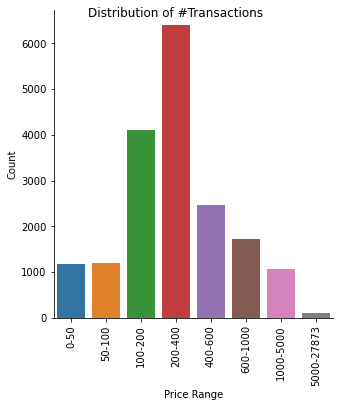

In [177]:
# sns.set_style("whitegrid")
# sns.set_context("talk")
g = sns.catplot(x = "labels", y = "count_price", data = count_price_df, kind = "bar")
g.fig.suptitle("Distribution of #Transactions")
g.set(xlabel = "Price Range", ylabel = "Count")
plt.xticks(rotation = 90)
g.savefig("basket_price_distribution.png", dmi = 300, bbox_inches = "tight")
plt.show()

## 2.2 Products

### 2.2.1 Find Keywords & Corresponding Frequencies

In [200]:
# ensure that there is no NANs in the clean_data dataset
clean_data.isnull().values.any()

False

We've assured that there is no null values in the cleaned dataset.

In [215]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

description_df = pd.DataFrame(clean_data["Description"].unique()).rename(columns = {0:"Description"})
# snowball stemmer
stemmer = nltk.stem.SnowballStemmer("english")
keywords = {}
count_keywords = dict() # the frequency of each keyword
keywords_forms = dict() # the various forms of each stem word
selected_stems = dict() # the representative of each stem word

for description in description_df["Description"]:
    description = description.lower()
    tokenized_description = nltk.word_tokenize(description)
    # null words in descriptions
    description_nulls = [word for (word, pos) in nltk.pos_tag(tokenized_description) if pos[:2] == "NN"]
    
    for n in description_nulls:
        stem_word = stemmer.stem(n)
        
        if stem_word in keywords:
            keywords[stem_word].add(n)
            count_keywords[stem_word] += 1
        else:
            keywords[stem_word] = {n}
            count_keywords[stem_word] = 1
            
    for stem in keywords.keys():
        if len(keywords[stem]) > 1:
            min_length = 1000000
            for k in keywords[stem]:
                if len(k) < min_length:
                    temp = k
                    min_length = len(k)
            selected_stems[stem] = temp
        else:
            selected_stems[stem] = list(keywords[stem])[0]

### 2.2.2 Visualization

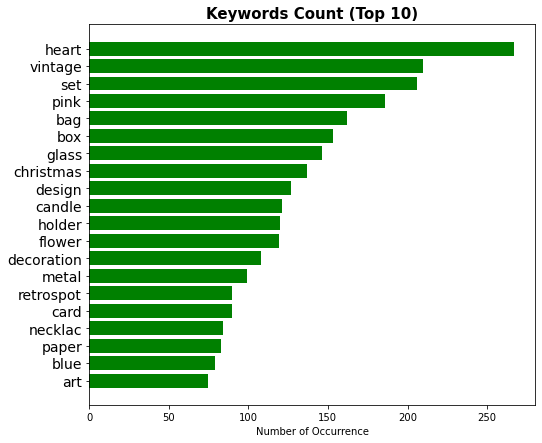

In [269]:
products = []
for k, v in count_keywords.items():
    products.append([selected_stems[k], v])
products.sort(key = lambda x: x[1], reverse = True)

# visualize the most frequent 20 keywords
word_list = products[0:20]

fig, ax = plt.subplots(figsize = (8, 7))
x_axis = [i for i,j in enumerate(word_list)]
x_label = [i[0] for i in word_list]
y_axis = [i[1] for i in word_list]
ax.barh(x_axis, y_axis, color = "green")
ax.invert_yaxis()
plt.yticks(x_axis, x_label, fontsize = 14)
plt.title("Keywords Count (Top 10)", fontsize = 15, fontweight='bold')
plt.xlabel("Number of Occurrence")
ax.figure.savefig("keyword_count.png", dmi = 300, bbox_inches = "tight")
plt.show()


From the result, we can see that the most popular products are relates to word heart, vintage, set, pink, bag, box, glass, christmas, design, candle, etc.

# 3 Customer Segmentation

## 3.1 Product Segmentation

### 3.1.1 Remove words with useless information

There are keywords that are useless for our analysis, such as those with very low frequencies, words of single letter, color words, punctuations, etc.. I will remove those unuseful words

In [222]:
product_list = []
for key, value in count_keywords.items():
    word = selected_stems[key]
    # remove words contains color
    if word in ["red", "orange", "yellow", "blue", "brown", "navy", "pink", "white", "black", "gray"]:
        continue
    if len(word) == 1:
        continue
    if ("+" in word) or ("/" in word):
        continue
    if value < 10:
        continue
    product_list.append([word, value])
product_list.sort(key = lambda x: x[1], reverse = True)
# display the first 5 elements: 
product_list[:5]
## product_list format: ["keyword", "frequency"]

[['heart', 267], ['vintage', 210], ['set', 206], ['bag', 162], ['box', 153]]

### 3.1.2 One-Hot Code Each product Description to matrix X

In [279]:
products = clean_data["Description"].unique()
X = pd.DataFrame()
for keyword, occurrence in product_list:
    X.loc[:, keyword] = list(map(lambda x: int(keyword.upper() in x), products))
X

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0         1        0    0    0    0      0          0       0       0       1   
1         0        0    0    0    0      0          0       0       0       0   
2         1        0    0    0    0      0          0       0       0       0   
3         0        0    0    0    0      0          0       0       0       0   
4         1        0    0    0    0      0          0       0       0       0   
...     ...      ...  ...  ...  ...    ...        ...     ...     ...     ...   
3849      0        0    0    0    0      0          0       0       0       0   
3850      0        0    0    0    0      0          0       0       0       0   
3851      0        0    0    0    0      0          0       0       0       0   
3852      0        0    0    0    0      0          0       0       0       0   
3853      1        0    0    0    0      0          0       0       0       1   

      ...  luggage  vanilla  animal  king  herb  english  jewellery  \
0     ...        0        0       0     0     0        0          0   
1     ...        0        0       0     0     0        0          0   
2     ...        0        0       0     0     0        0          0   
3     ...        0        0       0     0     0        0          0   
4     ...        0        0       0     0     0        0          0   
...   ...      ...      ...     ...   ...   ...      ...        ...   
3849  ...        0        0       0     0     0        0          0   
3850  ...        0        0       0     0     0        0          0   
3851  ...        0        0       0     0     0        0          0   
3852  ...        0        0       0     0     0        0          0   
3853  ...        0        0       0     0     0        0          0   

      container  boudicca  pastel  
0             0         0       0  
1             0         0       0  
2             0         0       0  
3             0         0       0  
4             0         0       0  
...         ...       ...     ...  
3849          0         0       0  
3850          0         0       0  
3851          0         0       0  
3852          0         0       0  
3853          0         0       0  

[3854 rows x 240 columns]

### 3.1.3 Add One-Hot encoded price range to matrix X

In [284]:
clean_data["UnitPrice"].describe()

count    380630.000000
mean          3.018531
std          19.417075
min           0.000000
25%           1.250000
50%           1.850000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

According to the statistic description of product prices, I decide to devide prices into 5 groups: (0, 1], (1,2], (2,3], (3, 5), >10.

In [290]:
threshold = [0, 1, 2, 3, 5, 10]
price_labels = []
# add emplty price range columns
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        label = ">%d"%(threshold[i])
    else:
        label = "%d~%d"%(threshold[i], threshold[i+1])
    price_labels.append(label)
    X.loc[:, label] = 0

# add one-hot encoded result to each price range column
for i, product in enumerate(products):
    avg_price = clean_data[clean_data["Description"] == product]["UnitPrice"].mean()

    for x, y in enumerate(threshold):
        min = threshold[x]
        if avg_price > min:
            index = x
    X.loc[i, price_labels[index]] = 1
display(X)

heart  vintage  set  bag  box  glass  christmas  design  candle  holder  \
0         1        0    0    0    0      0          0       0       0       1   
1         0        0    0    0    0      0          0       0       0       0   
2         1        0    0    0    0      0          0       0       0       0   
3         0        0    0    0    0      0          0       0       0       0   
4         1        0    0    0    0      0          0       0       0       0   
...     ...      ...  ...  ...  ...    ...        ...     ...     ...     ...   
3849      0        0    0    0    0      0          0       0       0       0   
3850      0        0    0    0    0      0          0       0       0       0   
3851      0        0    0    0    0      0          0       0       0       0   
3852      0        0    0    0    0      0          0       0       0       0   
3853      1        0    0    0    0      0          0       0       0       1   

      ...  jewellery  container  boudicca  pastel  0~1  1~2  2~3  3~5  5~10  \
0     ...          0          0         0       0    0    0    1    0     0   
1     ...          0          0         0       0    0    0    0    1     0   
2     ...          0          0         0       0    0    0    0    1     0   
3     ...          0          0         0       0    0    0    0    1     0   
4     ...          0          0         0       0    0    0    0    1     0   
...   ...        ...        ...       ...     ...  ...  ...  ...  ...   ...   
3849  ...          0          0         0       0    1    0    0    0     0   
3850  ...          0          0         0       0    1    0    0    0     0   
3851  ...          0          0         0       0    1    0    0    0     0   
3852  ...          0          0         0       0    1    0    0    0     0   
3853  ...          0          0         0       0    0    0    1    0     0   

      >10  
0       0  
1       0  
2       0  
3       0  
4       0  
...   ...  
3849    0  
3850    0  
3851    0  
3852    0  
3853    0  

[3854 rows x 246 columns]

### 3.1.4 Using K-Means to create clusters of products

#### 3.1.4.1 Decide optimal k

##### 1) Elbow Method

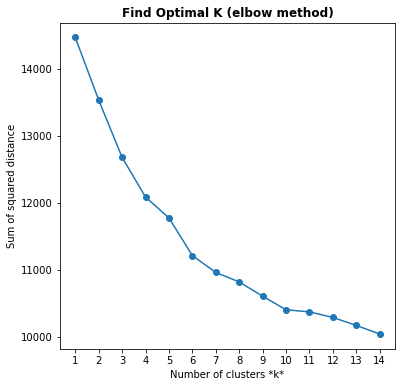

In [332]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


matrix = X.to_numpy()
# Run the Kmeans algorithm 
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k, n_init = 20)
    km.fit(matrix)
    sse.append(km.inertia_)
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xticks(list_k)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title("Find Optimal K (elbow method)", fontweight = "bold")
plt.savefig("elbow.png", dmi = 300, bbox_inches = "tight")
plt.show()

As shown in the plot above, SSE starts to flatten out when after k = 6 or k = 7.

##### 2) Silhouette Analysis

Silhouette analysis can be used to determine the degree of separation between clusters, scores closer to 1 indicates the cluster is far way from other clusters, indiciting a good seperation. I will draw the silhouette score for k = 6 and k = 7.

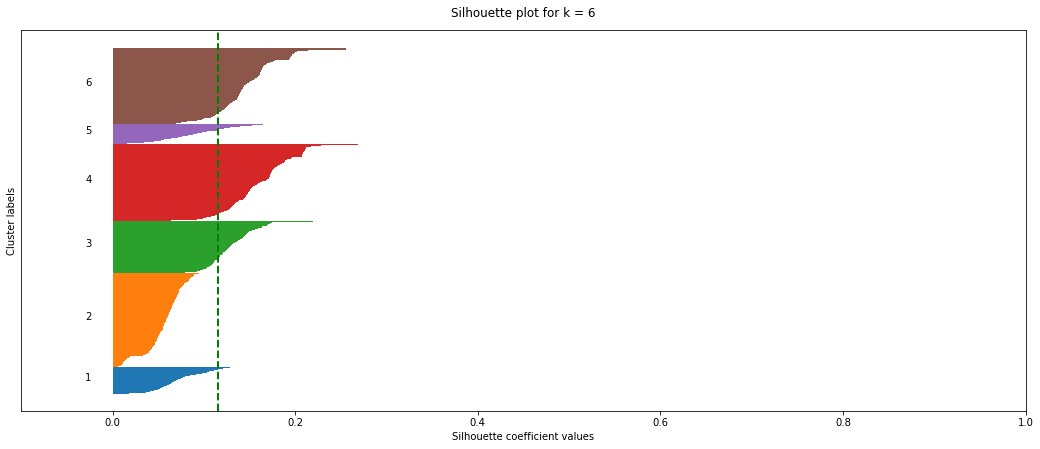

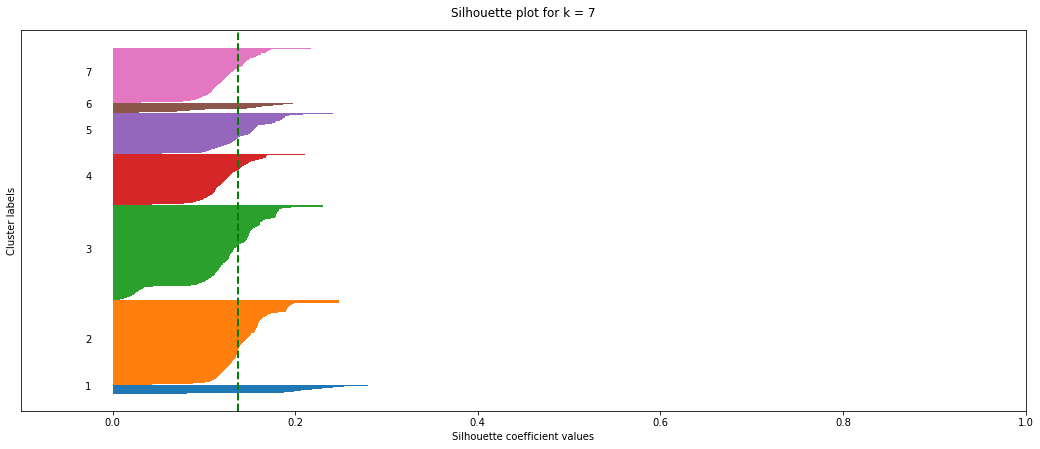

In [321]:
for i, k in enumerate([6, 7]):
    fig, ax1 = plt.subplots(figsize = (10, 26))
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(matrix)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(matrix, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for k = %d'%(k), y=1.02)
    ax1.figure.savefig("silhouette_score_" + str(i) +".png", dmi = 300, bbox_inches = "tight")
    


Since there is no negative scores in plot of k = 7, and all clusters being above the average, I think k = 7 is the optimal choice.

In [336]:
n_clusters = 7
score = -1
# we keep fitting the model until the average silhouette score larger than 0.14
while score < 0.1435:
    km = KMeans(n_clusters = n_clusters, n_init = 20)
    km.fit(matrix)
    clusters = km.predict(matrix)
    score = np.mean(silhouette_samples(matrix, clusters))
print("K = 7, Silhouette Score = %s"%(score))

K = 7, Silhouette Score = 0.1438146856335352


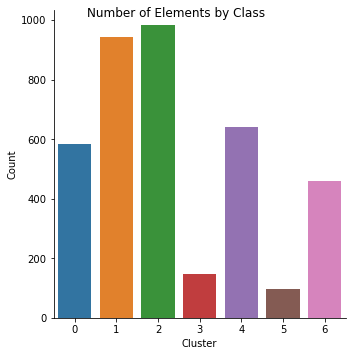

In [342]:
df_cluster = pd.DataFrame({"Label": clusters})
cluster_count = df_cluster.groupby("Label")["Label"].count().to_frame(name = "Count").reset_index()

g = sns.catplot(x = "Label", y = "Count", data = cluster_count, kind = "bar")
g.fig.suptitle("Number of Elements by Class")
g.set(xlabel = "Cluster", ylabel = "Count")
plt.show()
g.savefig("cluster_distributions.png", dmi = 300, bbox_inches = "tight")

### 3.1.5 WordCloud of each Cluster

#### 3.1.5.1 Find the Occurrence of each Keyword in each Cluster

In [357]:
products_df = pd.DataFrame(clean_data["Description"].unique())
words = [word for (word, frequency) in product_list]
occurrence = [dict() for i in range(n_clusters)]

for i in range(n_clusters):
    products_by_cluster = products_df.loc[clusters == i]
    
    for word in words:
        if word in ["red", "orange", "yellow", "blue", "brown", "navy", "pink", "white", 
                    "black", "gray", "set", "art", "spot", "tag", "heart"]:
            continue

        occurrence[i][word] = sum(products_by_cluster.loc[:, 0].str.contains(word.upper()))

In [364]:
# the occurrence of word 'vintage' in cluster 1
print(occurrence[0]['vintage']) 

39


#### 3.1.5.2 Plot WordCloud

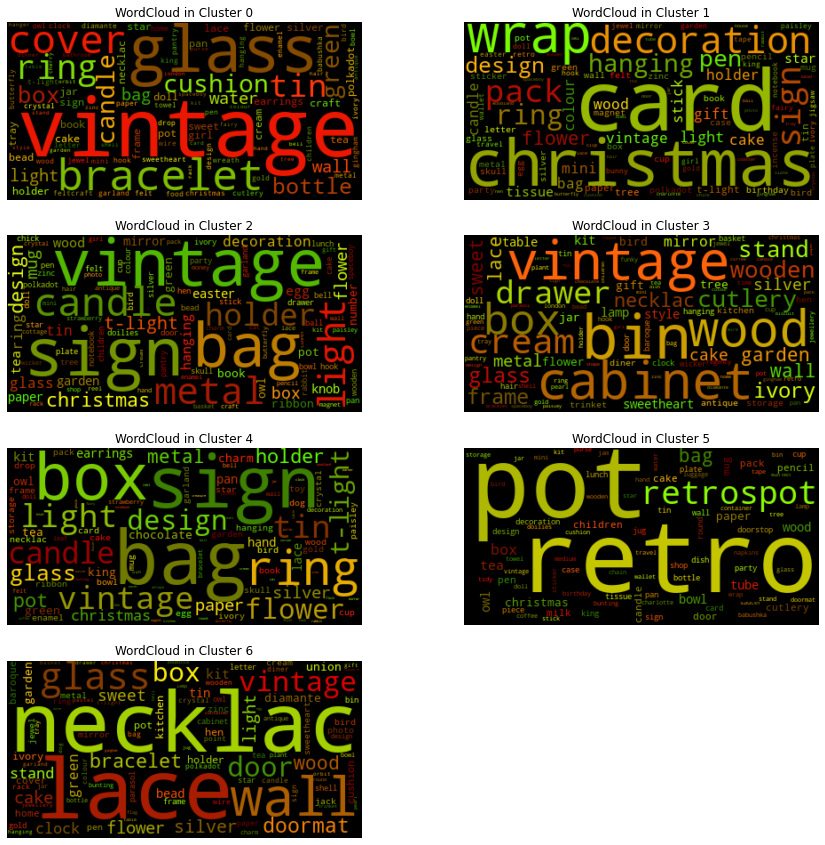

In [367]:
from wordcloud import WordCloud, STOPWORDS

import random
def color_func(word, font_size, position, orientation, random_state = None, **kwargs):
    return "hsl(%d, %d%%, %d%%)"% (int(100 * random.randint(1,255) / 255), 100, int(100 * random.randint(60, 140)/255))

def plot_wordcloud(cluster_list, i):
    ax =fig.add_subplot(4, 2, i)
    words = dict()
    most_frequent_words = cluster_list[0:150]
    for w in most_frequent_words:
        words[w[0]] = w[1]
        
        wordcloud = WordCloud(max_words = 100)
        wordcloud.generate_from_frequencies(words)
        ax.imshow(wordcloud.recolor(color_func = color_func, random_state = 0), interpolation = "bilinear")
        ax.axis("off")
        plt.title("WordCloud in Cluster %d"%(i-1))
        
fig = plt.figure(1, figsize=(15,15))
for i in range(n_clusters):
    cluster_word_occurrence = occurrence[i]
    list_ = []
    for key, value in cluster_word_occurrence.items():
        list_.append([key, value])
    list_.sort(key = lambda x: x[1], reverse = True)
    plot_wordcloud(list_, i+1)
plt.savefig("wordcloud.png", dmi = 300, bbox_inches = "tight")
plt.show()

##### According to the wordcloud, I will define each cluster as follows:
    - Cluster 0: jewelry (vintage style)
    - Cluster 1: Chrismas goods
    - Cluster 2: decorations (vintage style)
    - Cluster 3: furnitures
    - Cluster 4: decorations
    - Cluster 5: Retrospot
    - Cluster 6: jewelry
        

## 3.2 Customer Segmentation

### 3.2.1 Mapping Product Labels to each row

In [393]:
descriptions = clean_data["Description"].unique()
product_cluster = dict()
for key, value in zip(descriptions, clusters):
    product_cluster[key] = value
clean_data["product_category"] = clean_data.loc[:, "Description"].map(product_cluster)   

### 3.2.2 Amount Spent in each Prodcut Label by Basket

In [397]:
for i in range(n_clusters):
    col_name = "category%d"%(i)
    df_temp = clean_data[clean_data["product_category"] == i]
    price_temp = df_temp["Quantity"] * df_temp["UnitPrice"]
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    clean_data.loc[:, col_name] = price_temp
    clean_data[col_name].fillna(0, inplace = True)
display(clean_data.head(10))  

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
7     536366     22633               HAND WARMER UNION JACK         6   
9     536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
10    536367     22745           POPPY'S PLAYHOUSE BEDROOM          6   
11    536367     22748            POPPY'S PLAYHOUSE KITCHEN         6   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
2  2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00   
3  2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
4  2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
5  2010-12-01 08:26:00       7.65      17850  United Kingdom       15.30   
7  2010-12-01 08:28:00       1.85      17850  United Kingdom       11.10   
9  2010-12-01 08:34:00       1.69      13047  United Kingdom       54.08   
10 2010-12-01 08:34:00       2.10      13047  United Kingdom       12.60   
11 2010-12-01 08:34:00       2.10      13047  United Kingdom       12.60   

    product_category  category0  category1  category2  category3  category4  \
0                  4       0.00        0.0       0.00        0.0       15.3   
1                  0      20.34        0.0       0.00        0.0        0.0   
2                  0      22.00        0.0       0.00        0.0        0.0   
3                  0      20.34        0.0       0.00        0.0        0.0   
4                  0      20.34        0.0       0.00        0.0        0.0   
5                  6       0.00        0.0       0.00        0.0        0.0   
7                  4       0.00        0.0       0.00        0.0       11.1   
9                  2       0.00        0.0      54.08        0.0        0.0   
10                 4       0.00        0.0       0.00        0.0       12.6   
11                 4       0.00        0.0       0.00        0.0       12.6   

    category5  category6  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0  
3         0.0        0.0  
4         0.0        0.0  
5         0.0       15.3  
7         0.0        0.0  
9         0.0        0.0  
10        0.0        0.0  
11        0.0        0.0

In [402]:
basket_price_df = clean_data.groupby(["CustomerID", "InvoiceNo"])["TotalPrice"].sum().to_frame(name = "Basket Price").reset_index()
for i in range(n_clusters):
    col_name = "category" + str(i)
    basket_price_by_category = clean_data.groupby(["CustomerID", "InvoiceNo"], as_index = False)[col_name].sum()
    basket_price_df.loc[:, col_name] = basket_price_by_category
display(basket_price_df.head())

CustomerID InvoiceNo  Basket Price  category0  category1  category2  \
0      12347    537626        711.79     270.85      23.40      187.2   
1      12347    542237        475.39     151.50      84.34      118.0   
2      12347    549222        636.25     115.00      81.00      330.9   
3      12347    556201        382.52     168.76      41.40       74.4   
4      12347    562032        584.91     158.16      61.30      109.7   

   category3  category4  category5  category6  
0       0.00      83.40       22.5     124.44  
1      38.25      35.40       47.9       0.00  
2      38.25      35.70       35.4       0.00  
3       0.00      78.06        0.0      19.90  
4      38.25     119.70        0.0      97.80

### 3.2.3 Add Order Date each Basket 

In [409]:
clean_data["InvoiceDate_int"] = clean_data["InvoiceDate"].astype("int64")
avg_dates = clean_data.groupby(["CustomerID", "InvoiceNo"], as_index = False)["InvoiceDate_int"].mean()
basket_price_df["InvoiceDate"] = pd.to_datetime(avg_dates["InvoiceDate_int"])

# delete rows with basket price value equals to 0
basket_price_df = basket_price_df[basket_price_df["Basket Price"] > 0]

display(basket_price_df.head())

CustomerID InvoiceNo  Basket Price  category0  category1  category2  \
0      12347    537626        711.79     270.85      23.40      187.2   
1      12347    542237        475.39     151.50      84.34      118.0   
2      12347    549222        636.25     115.00      81.00      330.9   
3      12347    556201        382.52     168.76      41.40       74.4   
4      12347    562032        584.91     158.16      61.30      109.7   

   category3  category4  category5  category6                   InvoiceDate  
0       0.00      83.40       22.5     124.44 2010-12-07 14:57:00.000001024  
1      38.25      35.40       47.9       0.00 2011-01-26 14:29:59.999999744  
2      38.25      35.70       35.4       0.00 2011-04-07 10:42:59.999999232  
3       0.00      78.06        0.0      19.90 2011-06-09 13:01:00.000000256  
4      38.25     119.70        0.0      97.80 2011-08-02 08:48:00.000000000

In [411]:
# range of the order dates
min_date = basket_price_df["InvoiceDate"].min()
max_date = basket_price_df["InvoiceDate"].max()
print("The range of the order dates is from {} to {}".format(min_date, max_date))

The range of the order dates is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


### 3.2.4 Orders Group by Customer

In [419]:
customer_transactions = basket_price_df.groupby(["CustomerID"])["Basket Price"].agg(
     NumberPurchased = "count",
     MinPurchaseAmount = "min",
     AvgPurchaseAmount = "mean",
     MaxPurchaseAmount ="max",
     TotalPurchaseAmount = "sum"
)

for i in range(n_clusters):
    col_name = "category"+str(i)
    new_col_name = "category" + str(i) + "(%)"
    customer_transactions[new_col_name] = round(basket_price_df.groupby("CustomerID")[col_name].sum() / customer_transactions["TotalPurchaseAmount"] * 100, 2)

# customer_transactions.reset_insex(inplace = True)
display(customer_transactions.head())

NumberPurchased  MinPurchaseAmount  AvgPurchaseAmount  \
CustomerID                                                          
12347                     7             224.82         615.714286   
12348                     4             227.44         449.310000   
12349                     1            1757.55        1757.550000   
12350                     1             334.40         334.400000   
12352                     7             124.55         337.987143   

            MaxPurchaseAmount  TotalPurchaseAmount  category0(%)  \
CustomerID                                                         
12347                 1294.32              4310.00         28.61   
12348                  892.80              1797.24          0.00   
12349                 1757.55              1757.55          7.31   
12350                  334.40               334.40          0.00   
12352                  840.30              2365.91         14.10   

            category1(%)  category2(%)  category3(%)  category4(%)  \
CustomerID                                                           
12347              11.24         26.09          4.44         19.57   
12348              35.69         41.95         20.03          0.00   
12349               2.77         24.77         25.63          9.50   
12350               5.59         48.44         11.96         27.90   
12352               1.31         15.00         50.05          4.11   

            category5(%)  category6(%)  
CustomerID                              
12347               2.45          7.60  
12348               2.32          0.00  
12349              13.47         16.56  
12350               6.10          0.00  
12352               0.63         14.81

###### Add PurchaseInterval column

In [424]:
first_purchase = basket_price_df.groupby("CustomerID")["InvoiceDate"].min()
last_purchase = basket_price_df.groupby("CustomerID")["InvoiceDate"].max()

order_date_range = (last_purchase - first_purchase).astype('timedelta64[D]')
customer_transactions.loc[:, "PuchaseInterval(days)"] = round(order_date_range / customer_transactions["NumberPurchased"])
# those who only purchased once, change the purchase interval from 0 to 365
customer_transactions["PuchaseInterval(days)"] = np.where(customer_transactions["NumberPurchased"] == 1, 365, customer_transactions["PuchaseInterval(days)"])
display(customer_transactions.head(10))

NumberPurchased  MinPurchaseAmount  AvgPurchaseAmount  \
CustomerID                                                          
12347                     7             224.82         615.714286   
12348                     4             227.44         449.310000   
12349                     1            1757.55        1757.550000   
12350                     1             334.40         334.400000   
12352                     7             124.55         337.987143   
12353                     1              89.00          89.000000   
12354                     1            1079.40        1079.400000   
12355                     1             459.40         459.400000   
12356                     3              58.35         937.143333   
12357                     1            6207.67        6207.670000   

            MaxPurchaseAmount  TotalPurchaseAmount  category0(%)  \
CustomerID                                                         
12347                 1294.32              4310.00         28.61   
12348                  892.80              1797.24          0.00   
12349                 1757.55              1757.55          7.31   
12350                  334.40               334.40          0.00   
12352                  840.30              2365.91         14.10   
12353                   89.00                89.00          0.00   
12354                 1079.40              1079.40         10.97   
12355                  459.40               459.40         25.27   
12356                 2271.62              2811.43          3.63   
12357                 6207.67              6207.67         19.53   

            category1(%)  category2(%)  category3(%)  category4(%)  \
CustomerID                                                           
12347              11.24         26.09          4.44         19.57   
12348              35.69         41.95         20.03          0.00   
12349               2.77         24.77         25.63          9.50   
12350               5.59         48.44         11.96         27.90   
12352               1.31         15.00         50.05          4.11   
12353               0.00         13.03         44.72         19.89   
12354              10.23         24.96          6.10          7.74   
12355               0.00         53.29          9.88         11.56   
12356              13.22         28.06         20.48         12.59   
12357               4.27         16.38          7.15          9.66   

            category5(%)  category6(%)  PuchaseInterval(days)  
CustomerID                                                     
12347               2.45          7.60                   52.0  
12348               2.32          0.00                   70.0  
12349              13.47         16.56                  365.0  
12350               6.10          0.00                  365.0  
12352               0.63         14.81                   37.0  
12353               0.00         22.36                  365.0  
12354              28.92         11.08                  365.0  
12355               0.00          0.00                  365.0  
12356              11.80         10.22                  101.0  
12357              22.87         20.13                  365.0

### 3.2.5 Customer Segmentatoin (K-Means)

#### 3.2.5.1 data preprocessing

In [427]:

from sklearn.preprocessing import StandardScaler


customer_analysis= customer_transactions.copy(deep = True)
col_names = ['NumberPurchased', 'MinPurchaseAmount', 'AvgPurchaseAmount',
       'MaxPurchaseAmount', 'TotalPurchaseAmount', 'category0(%)',
       'category1(%)', 'category2(%)', 'category3(%)', 'category4(%)',
       'category5(%)', 'category6(%)', "PuchaseInterval(days)"]
customer_matrix = customer_analysis[col_names].to_numpy()

scaler = StandardScaler()
scaler.fit(customer_matrix)
# standarlization
scaled_customer_matrix = scaler.transform(customer_matrix)

#### 3.2.5.2 Find Optimal K

##### 1) Elbow Method

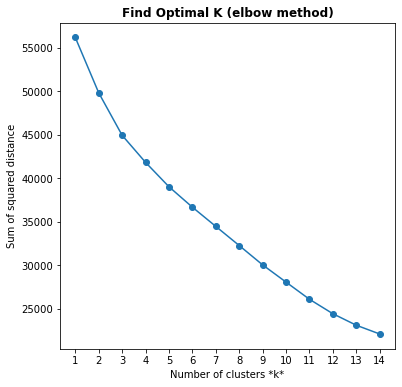

In [429]:
# Run the Kmeans algorithm 
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k, n_init = 20)
    km.fit(scaled_customer_matrix)
    sse.append(km.inertia_)
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xticks(list_k)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title("Find Optimal K (elbow method)", fontweight = "bold")
plt.savefig("elbow_method_customer.png", dmi = 300, bbox_inches = "tight")
plt.show()

There is no obvious elbow point in the plot above, thus I will choose the k which will provide the highest silhouette score.

##### 2) Silhouette Score

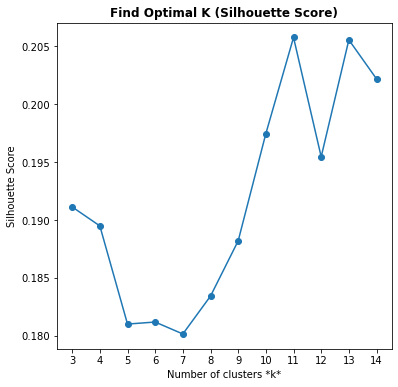

In [443]:
# Run the Kmeans algorithm 
silhouette_scores = []
list_k = list(range(3, 15))

for k in list_k:
    km = KMeans(n_clusters=k, n_init = 20)
    km.fit(scaled_customer_matrix)
    clusters_temp = km.predict(scaled_customer_matrix)
    score = silhouette_score(scaled_customer_matrix, clusters_temp)
    silhouette_scores.append(score)
    

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, silhouette_scores, '-o')
plt.xticks(list_k)
plt.xlabel('Number of clusters *k*')
plt.ylabel('Silhouette Score')
plt.title("Find Optimal K (Silhouette Score)", fontweight = "bold")
plt.savefig("silhouette_score_line_customer.png", dmi = 300, bbox_inches = "tight")
plt.show()

When k = 11, silhoutte reach the highest score, and thus I choose n_clusters = 11.

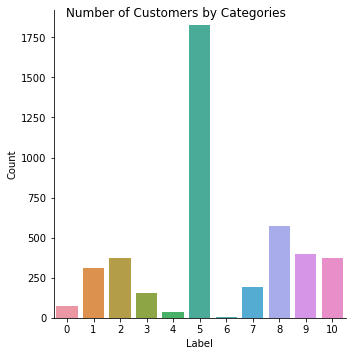

In [446]:
kmeans_classifier = KMeans(n_clusters = 11, n_init = 20)
kmeans_classifier.fit(scaled_customer_matrix)
customer_clusters = kmeans_classifier.predict(scaled_customer_matrix)

customer_cluster_df = pd.DataFrame({"Label": customer_clusters})
customer_cluster_count = customer_cluster_df.groupby("Label")["Label"].count().to_frame(name = "Count").reset_index()

g = sns.catplot(x = "Label", y = "Count", data = customer_cluster_count, kind = "bar")
g.fig.suptitle("Number of Customers by Categories")
g.savefig("customer_cluster_count.png", dmi = 300, bbox_inches = "tight")
plt.show()

In [450]:
customer_analysis = customer_transactions.copy()
customer_analysis.loc[:, "CustomerCategory"] = customer_clusters
display(customer_analysis.head())

NumberPurchased  MinPurchaseAmount  AvgPurchaseAmount  \
CustomerID                                                          
12347                     7             224.82         615.714286   
12348                     4             227.44         449.310000   
12349                     1            1757.55        1757.550000   
12350                     1             334.40         334.400000   
12352                     7             124.55         337.987143   

            MaxPurchaseAmount  TotalPurchaseAmount  category0(%)  \
CustomerID                                                         
12347                 1294.32              4310.00         28.61   
12348                  892.80              1797.24          0.00   
12349                 1757.55              1757.55          7.31   
12350                  334.40               334.40          0.00   
12352                  840.30              2365.91         14.10   

            category1(%)  category2(%)  category3(%)  category4(%)  \
CustomerID                                                           
12347              11.24         26.09          4.44         19.57   
12348              35.69         41.95         20.03          0.00   
12349               2.77         24.77         25.63          9.50   
12350               5.59         48.44         11.96         27.90   
12352               1.31         15.00         50.05          4.11   

            category5(%)  category6(%)  PuchaseInterval(days)  \
CustomerID                                                      
12347               2.45          7.60                   52.0   
12348               2.32          0.00                   70.0   
12349              13.47         16.56                  365.0   
12350               6.10          0.00                  365.0   
12352               0.63         14.81                   37.0   

            CustomerCategory  
CustomerID                    
12347                      5  
12348                      1  
12349                      0  
12350                      8  
12352                      3

In [458]:
customer_by_category_df = pd.DataFrame()
for i in range(11):
    temp = customer_analysis[customer_analysis["CustomerCategory"] == i].mean().to_frame().T
    temp["NumberOfCustomers"] = customer_analysis[customer_analysis["CustomerCategory"] == i].shape[0]
    customer_by_category_df = pd.concat([customer_by_category_df, temp])
customer_by_category_df["CustomerCategory"] = list(range(11))
customer_by_category_df.reset_index(drop = True, inplace = True)

display(customer_by_category_df)

NumberPurchased  MinPurchaseAmount  AvgPurchaseAmount  MaxPurchaseAmount  \
0          1.644737        1838.278816        2125.267072        2476.343039   
1          2.163987         198.414437         245.137492         310.833794   
2          2.275401         236.786580         297.933167         364.665484   
3          1.896774         224.763484         263.374657         326.047935   
4         50.916667          45.140833        1111.915125        4784.988333   
5          6.010947         170.076415         360.451045         615.258911   
6         42.166667         588.020000        5370.464857       21255.830000   
7          2.817708         229.480833         290.314552         357.612240   
8          1.680702         271.486000         300.875895         334.240719   
9          2.598997         221.274113         277.888612         344.572832   
10         1.874332         269.695802         312.211248         368.945722   

    TotalPurchaseAmount  category0(%)  category1(%)  category2(%)  \
0           3623.965408     16.813158     10.468158     21.366842   
1            557.093441      6.638489     50.485723     19.842572   
2            726.856955      8.803422      7.689599     15.424840   
3            531.694258      7.271935      3.622968      9.812968   
4          35744.153056     15.740000     11.123333     20.694722   
5           2150.391992     16.192332     12.542978     25.793492   
6         159697.828333     15.256667      5.970000     20.273333   
7            814.212760      9.262760     11.173958     16.314375   
8            479.280089      8.447140     11.683702     51.178754   
9            730.831707     11.964862      5.871103     12.191855   
10           662.742807     45.743503      7.949118     14.410588   

    category3(%)  category4(%)  category5(%)  category6(%)  \
0       9.742368     20.421316      7.764211     13.425395   
1       2.301061     11.181029      3.473119      6.078006   
2       3.131631     53.138128      4.444947      7.367005   
3      54.451290      9.530774      2.299226     13.010516   
4       6.955278     23.158611      9.064722     13.262778   
5       5.908248     20.608916      5.707307     13.246858   
6       6.185000     25.916667      6.876667     19.525000   
7       4.676615     12.034583     36.571823      9.966042   
8       3.748263     14.037737      4.081965      6.822491   
9       6.188722     12.571729      3.730902     47.480977   
10      4.268422     12.896390      3.423235     11.308583   

    PuchaseInterval(days)  CustomerCategory  NumberOfCustomers  
0              262.223684                 0                 76  
1              220.360129                 1                311  
2              229.836898                 2                374  
3              255.161290                 3                155  
4               10.972222                 4                 36  
5               43.453202                 5               1827  
6               15.000000                 6                  6  
7              203.552083                 7                192  
8              273.698246                 8                570  
9              223.147870                 9                399  
10             264.633690                10                374

#### 3.2.5.3 Visualization

In [463]:
features = customer_by_category_df[['NumberPurchased', 'MinPurchaseAmount', 'AvgPurchaseAmount',
       'MaxPurchaseAmount', 'TotalPurchaseAmount', 'category0(%)',
       'category1(%)', 'category2(%)', 'category3(%)', 'category4(%)',
       'category5(%)', 'category6(%)', 'PuchaseInterval(days)']].to_numpy()
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = go.Figure()

for i in range(11):

    fig.add_trace(
        go.Scatterpolar(
          r=features[i],
          theta=['NumberPurchased', 'MinPurchaseAmount', 'AvgPurchaseAmount',
           'MaxPurchaseAmount', 'TotalPurchaseAmount', 'category0(%)',
           'category1(%)', 'category2(%)', 'category3(%)', 'category4(%)',
           'category5(%)', 'category6(%)', 'PuchaseInterval(days)'],
          fill='toself'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False
    ),
  ),
  showlegend=False
)

fig.show()

From the radar plot, we can see that customer category 5 which has the most numbero customers like to purchase product 0 and 1(vintage style jewlry and Chrismas goods)

# 4 Customer Category Prediction

## 4.1 Data Preprocessing 

In [476]:
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier


X = customer_analysis[['NumberPurchased', 'MinPurchaseAmount', 'AvgPurchaseAmount',
           'MaxPurchaseAmount', 'TotalPurchaseAmount', 'category0(%)',
           'category1(%)', 'category2(%)', 'category3(%)', 'category4(%)',
           'category5(%)', 'category6(%)', 'PuchaseInterval(days)']].values
Y = customer_analysis["CustomerCategory"].values

# transformation
scaler = StandardScaler() 
scaler.fit(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size = 0.2)

## 4.2 HyperParameter Tuning

In [569]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

def model_evaluation(classifier):
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    return score

### 4.2.1 max_features in Decision Tree

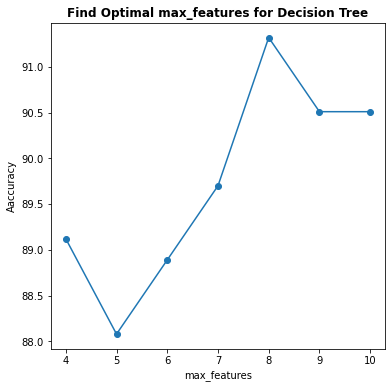

In [589]:
scores = []
max_features_range = [4, 5, 6, 7, 8, 9, 10]
for i in max_features_range:
    tree_classifer = tree.DecisionTreeClassifier(criterion="entropy", max_features=i, random_state = 0)
    score = model_evaluation(tree_classifer)
    scores.append(score)
    
plt.figure(figsize=(6, 6))
plt.plot(max_features_range, scores, '-o')
plt.xticks(max_features_range)
plt.xlabel('max_features')
plt.ylabel('Aaccuracy')
plt.title("Find Optimal max_features for Decision Tree", fontweight = "bold")
plt.savefig("max_features_decision_tree.png", dmi = 300, bbox_inches = "tight")
plt.show()


From the plot above, max_features = 8 is the optimal choice

### 4.2.2 n_neighbors in KNN

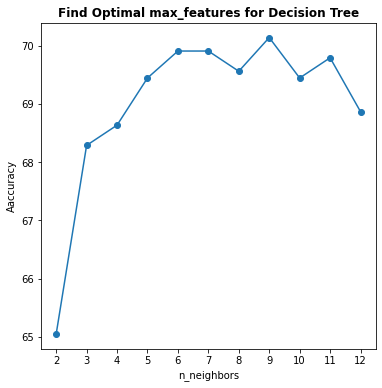

In [591]:
from sklearn.neighbors import KNeighborsClassifier
accuracies = []
n_neighbors_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
for i in n_neighbors_range:
    knn_classifer = KNeighborsClassifier(n_neighbors = i)
    accuracy = model_evaluation(knn_classifer)
    accuracies.append(accuracy)

plt.figure(figsize=(6, 6))
plt.plot(n_neighbors_range, accuracies, '-o')
plt.xticks(n_neighbors_range)
plt.xlabel('n_neighbors')
plt.ylabel('Aaccuracy')
plt.title("Find Optimal max_features for Decision Tree", fontweight = "bold")
plt.savefig("knn_tuning.png", dmi = 300, bbox_inches = "tight")
plt.show()

From the plot above, n_neighbors = 9 is the optimal choice

### 4.2.3 n_estimators and max_depth in Random Forest

In [544]:

n_estimators_range = [3, 4, 5, 6, 7, 8]
max_depth_range = [3, 4, 5, 6, 7, 8]

random_forest_dict = {}

for i in n_estimators_range:
    accuracies = []
    for j in max_depth_range:
        random_tree_classifier = RandomForestClassifier(n_estimators=5, max_depth=5, criterion="entropy")
        accuracy = model_evaluation(random_tree_classifier, "Random Forest")
        accuracies.append(accuracy)
    random_forest_dict["n_estimator="+str(i)] = accuracies


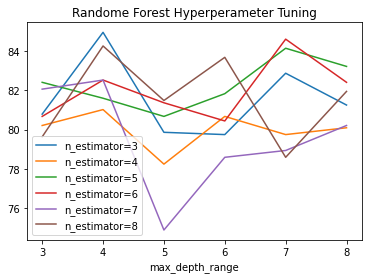

In [547]:
df = pd.DataFrame(random_forest_dict)
df["max_depth_range"] = max_depth_range
df.set_index("max_depth_range", inplace = True, drop = True)
df
ax = df.plot(title = "Randome Forest Hyperperameter Tuning")
ax.figure.savefig("random_forest_tuning.png", dmi = 300, bbox_inches = "tight")


According to the plot above, I will set n_estimators = 3, and max_depth = 4 for Random Forest classifier.

## 4.3 Optimal Customer Category Prediction Model

In [592]:
classifier_names = ["SVM (linear)", "SVM (Gussian)", "SVM (Polynomial)", "Decision Tree", \
                    "LDA", "Naive Bayes", "Logistic Regression", "AdaBoost", "Random Forest", "KNN"]


# SVM (liner)
svm_classifier_linear = svm.SVC(kernel="linear")

# SVM (Gussian)
svm_classifier_rbf = svm.SVC(kernel="rbf")

# SVM (polynomial)
svm_classifier_poly = svm.SVC(kernel="rbf")

# Decision Tree
tree_classifer = tree.DecisionTreeClassifier(criterion="entropy", max_features=8, random_state = 0)

# LDA
lda_classifer = LDA(n_components = 2)

# Naive Bayes
NB_classifier = GaussianNB()

# Logistic Regression
logi_classifier = LogisticRegression(max_iter=10000, solver = "saga")

# AdaBoost
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state = 0)

# Random Forest
random_tree = RandomForestClassifier(n_estimators=3, max_depth=4, criterion="entropy")

# KNN
knn_classifer = KNeighborsClassifier(n_neighbors = 9)

# Model Evaluation
classifier_accuracies = []
for i in [svm_classifier_linear, svm_classifier_rbf, svm_classifier_poly, tree_classifer, lda_classifer,\
          NB_classifier, logi_classifier, adaboost_classifier, random_tree, knn_classifer]:
    accuracy = model_evaluation(i)
    classifier_accuracies.append(accuracy)

In [624]:
# build a dataframe
model_accuracy_df = pd.DataFrame({"Model Name":classifier_names, "Accuracy":classifier_accuracies})
model_accuracy_df["Number"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
model_accuracy_df.set_index("Number", inplace = True, drop = True)
model_accuracy_df.sort_values("Accuracy", ascending = False)

Model Name   Accuracy
Number                                
1              SVM (linear)  97.685185
4             Decision Tree  91.319444
5                       LDA  90.277778
6               Naive Bayes  87.152778
9             Random Forest  71.875000
10                      KNN  70.138889
8                  AdaBoost  53.935185
7       Logistic Regression  52.777778
2             SVM (Gussian)  52.430556
3          SVM (Polynomial)  52.430556

#### SVM (linear) is the Optimal Model for Customer Category Prediction with 98% accuracy for this e-commerce company